#Deep Learning Architectures Assignment 2
The goal is to design and train a neural network for a regression task.
Detailed requirements were presented during the last lecture.

#Summary
#Dataset
* The dataset contains 2210 examples.
* Each example consists of 2500 time steps.
* In each time step, 8 values are recorded.
* The result consists of two real numbers representing the coordinates.

##TODO:
* Split the dataset into three sets: test, validation, and training.
* Choose an architecture and design the model.
* Design the training procedure.
* Present the results. \\
// A correctly trained model should make predictions with an average error of < 2.

##What will be evaluated:
* Understanding of the topic, exploration of the dataset, justification of architecture choice [5 points]
* Correctness of the training implementation [5 points]
* Error obtained on test and validation data [5 points]
* Presentation of the achieved results [5 points]


##Extended task for extra points:
* Design a model for noisy data.
* To add noise, use the addNoise function.
* Start tests with low noise: 0.01 or 0.001.

In [119]:
from urllib.request import urlopen
import numpy as np
import pickle
import os

def download_part(filename):
  base_url = f"https://github.com/pa-k/AGU/blob/main/assignment2/{filename}?raw=true"
  url = urlopen(base_url)
  binary_data = url.read()
  with open(filename,"wb") as f:
    f.write(binary_data)

def loadDataset():
    parts = ["DLAA2.0.pkl", "DLAA2.1.pkl", "DLAA2.2.pkl", "DLAA2.3.pkl"]
    cData = b''
    for part in parts:
        if not os.path.exists(part):
          download_part(part)
        with open(part, "rb") as f:
            cData += pickle.load(f)
    return pickle.loads(cData)

def addNoise(input, noiseLevel=0.1):
  shape = input.shape
  noise = np.random.randn(*shape)*noiseLevel*np.max(input)
  return input+noise


##Load dataset

In [120]:
x, y = loadDataset()
print(x.shape)
print(y.shape)
print(y[1000])

(2210, 2500, 8)
(2210, 2)
[23 14]


# Your solution - 184657 Panfil Wojciech

In [121]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import torch

In [122]:
total_samples = len(x)
train_ratio=0.7
val_ratio=0.15
test_ratio=0.15

train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
indices = np.random.permutation(total_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

x_train, y_train = x[train_indices], y[train_indices]
x_val, y_val = x[val_indices], y[val_indices]
x_test, y_test = x[test_indices], y[test_indices]


First, the dataset was divided into training, validation, and testing in a 14:3:3 ratio.
The data were analyzed for the possibility of normalization, and standardization. Due to the high irregularity, normalization has been applied.

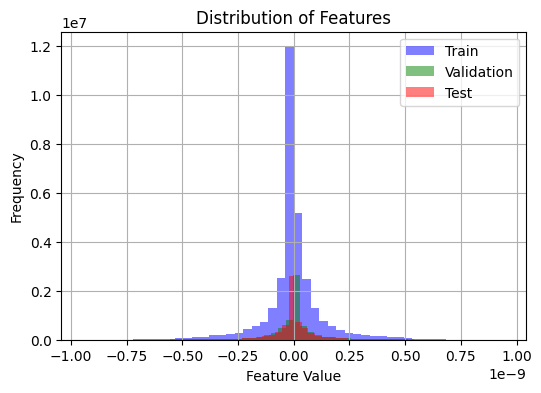

In [123]:
plt.figure(figsize=(6, 4))
plt.hist(x_train.flatten(), bins=50, alpha=0.5, label='Train', color='blue')
plt.hist(x_val.flatten(), bins=50, alpha=0.5, label='Validation', color='green')
plt.hist(x_test.flatten(), bins=50, alpha=0.5, label='Test', color='red')
plt.title('Distribution of Features')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

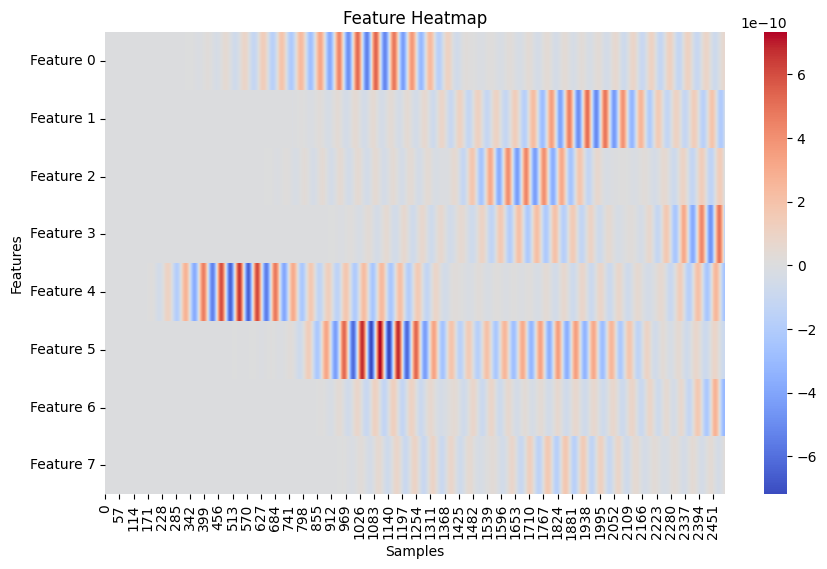

In [124]:
data_point = x_train[0]
df_data_point = pd.DataFrame(data_point, columns=[f'Feature {i}' for i in range(data_point.shape[1])])
plt.figure(figsize=(10, 6))
sns.heatmap(df_data_point.T, annot=False, cmap='coolwarm', cbar=True)
plt.title('Feature Heatmap')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

In [125]:
scaler = Normalizer()
x_train_normalized = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val_normalized = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
x_test_normalized = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [126]:
x_train_tensor = torch.tensor(x_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_normalized, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

For this regression task, multiple architectures have been analyzed.
The first choice was LSTM architecture, which should be great for predicting data based on time series.
In both cases, Huber loss is used for regression because it combines the best properties of Mean Squared Error (MSE) and Mean Absolute Error (MAE), being less sensitive to outliers than MSE while still being differentiable, which aids in gradient-based optimization. 
To calculate error rate, manhattan metric is used (Euclidean distance).

In [127]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_prob, bidirectional=True)

        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.batch_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

input_size = 8
hidden_size = 128
num_layers = 2
output_size = 2
num_epochs = 20
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob=0.5)
model.to(device)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)


In [128]:
num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_error = 0.0
    total_samples = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        outputs_cpu = outputs.cpu().detach().numpy()
        targets_cpu = targets.cpu().detach().numpy()
        total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
        total_samples += inputs.size(0)

    avg_error = total_error / total_samples
    print(f'Avg error on train: {avg_error:.2f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_error = 0.0
        total_samples = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            outputs_cpu = outputs.cpu().detach().numpy()
            targets_cpu = targets.cpu().detach().numpy()
            total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
            total_samples += inputs.size(0)

        avg_error = total_error / total_samples
        print(f'Avg error on val: {avg_error:.2f}')

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    # scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Avg error on train: 37.90
Avg error on val: 36.72
Epoch 1/15, Train Loss: 24.48354724961884, Val Loss: 23.408778624101117
Avg error on train: 37.13
Avg error on val: 35.69
Epoch 2/15, Train Loss: 23.922483054959045, Val Loss: 22.618724822998047
Avg error on train: 35.25
Avg error on val: 33.87
Epoch 3/15, Train Loss: 22.452404645024515, Val Loss: 21.233591426502574
Avg error on train: 31.37
Avg error on val: 32.24
Epoch 4/15, Train Loss: 19.619532799234197, Val Loss: 20.049410646611992
Avg error on train: 26.26
Avg error on val: 19.58
Epoch 5/15, Train Loss: 16.275209718821, Val Loss: 11.704023881392045
Avg error on train: 22.23
Avg error on val: 23.70
Epoch 6/15, Train Loss: 13.73292977469308, Val Loss: 14.233043323863637
Avg error on train: 19.68
Avg error on val: 18.50
Epoch 7/15, Train Loss: 12.264080903968033, Val Loss: 11.1129752072421
Avg error on train: 18.88
Avg error on val: 18.20
Epoch 8/15, Train Loss: 11.73432392976722, Val Loss: 10.957625909285111
Avg error on train: 18.6

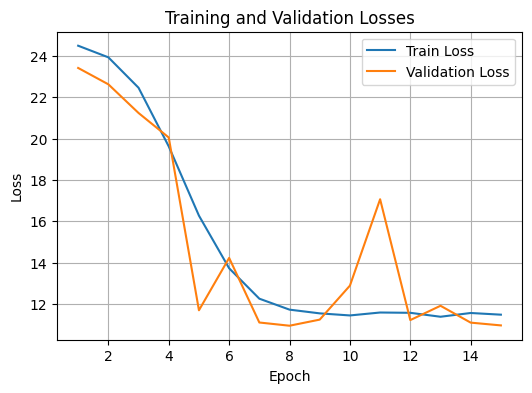

In [129]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
test_loss = 0.0
total_error = 0.0
total_samples = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        outputs_cpu = outputs.cpu().detach().numpy()
        targets_cpu = y_batch.cpu().detach().numpy()
        total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
        total_samples += X_batch.size(0)

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
avg_error = total_error / total_samples
print(f'Avg error on test: {avg_error:.2f}')

Test Loss: 11.2833
Avg error on test: 17.89


However this choice turned out to be difficult to use due to extensive length of training, especially when adding multiple LSTM cells. Therefore at some point of performing GridSearch for hyperparameters decision has been made to try out another model - CNN model + fully-connected layers at the end. Properly adopted CNN, traditionally used for image processing tasks, can also handle sequential data by applying convolutions across the temporal dimension.

In [131]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 625, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU6(inplace=True)
        self.dropout = nn.Dropout(0.2)
        self.layer_norm = nn.LayerNorm(256)

        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.layer_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = RegressionModel()

This model turned out to be much better in handling this task, what will be visible on the learning loss chart below and on the test dataset error rate.

In [132]:
model.to(device)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters())

In [133]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_error = 0.0
    total_samples = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        outputs_cpu = outputs.cpu().detach().numpy()
        targets_cpu = targets.cpu().detach().numpy()
        total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
        total_samples += inputs.size(0)

    avg_error = total_error / total_samples
    print(f'Avg error on train: {avg_error:.2f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_error = 0.0
        total_samples = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            outputs_cpu = outputs.cpu().detach().numpy()
            targets_cpu = targets.cpu().detach().numpy()
            total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
            total_samples += inputs.size(0)

        avg_error = total_error / total_samples
        print(f'Avg error on val: {avg_error:.2f}')

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Avg error on train: 23.61
Avg error on val: 17.94
Epoch 1/100, Train Loss: 14.693833857166524, Val Loss: 10.94580346887762
Avg error on train: 18.08
Avg error on val: 18.00
Epoch 2/100, Train Loss: 11.312284021961446, Val Loss: 11.042902859774502
Avg error on train: 18.04
Avg error on val: 18.03
Epoch 3/100, Train Loss: 11.330438185711296, Val Loss: 11.076468641107732
Avg error on train: 18.09
Avg error on val: 18.00
Epoch 4/100, Train Loss: 11.351534240099848, Val Loss: 11.04838839444247
Avg error on train: 18.02
Avg error on val: 18.02
Epoch 5/100, Train Loss: 11.288614156294843, Val Loss: 11.07090611891313
Avg error on train: 18.01
Avg error on val: 17.89
Epoch 6/100, Train Loss: 11.276508623239945, Val Loss: 10.93314977125688
Avg error on train: 18.01
Avg error on val: 17.92
Epoch 7/100, Train Loss: 11.280340194702148, Val Loss: 10.978606744246049
Avg error on train: 17.92
Avg error on val: 18.02
Epoch 8/100, Train Loss: 11.237337365442393, Val Loss: 11.089133696122603
Avg error on

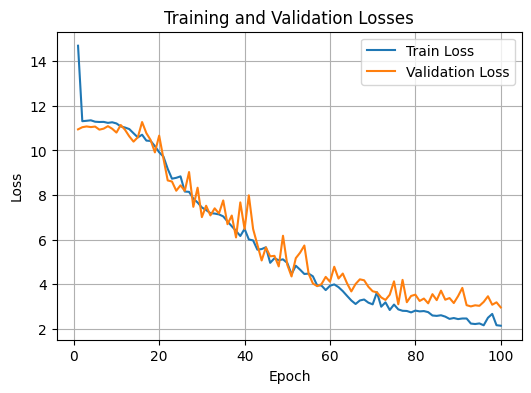

In [134]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
test_loss = 0.0
total_error = 0.0
total_samples = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        outputs_cpu = outputs.cpu().detach().numpy()
        targets_cpu = y_batch.cpu().detach().numpy()
        total_error += np.sqrt(np.power(outputs_cpu[:, 0] - targets_cpu[:, 0], 2) + np.power(outputs_cpu[:, 1] - targets_cpu[:, 1], 2)).sum().item()
        total_samples += X_batch.size(0)

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
avg_error = total_error / total_samples
print(f'Avg error on test: {avg_error:.2f}')

Test Loss: 2.8053
Avg error on test: 5.16


Unfortunately, despite the greatest will, the author of the experiment did not manage to achieve the expected result - lowering the error to below the value of 2. This may be due to insufficient matching of hyperparameters, too simple network design or inadequate choice of architecture for the expected results.